# Neural Network

The study of neural networks (NNs) started with Frank Rosenblatt in 1958 with the formalism of the perceptron. The perceptron consists of combining the features in a neural network $x = [x_1 \dots, x_k]$ with a vector of predefined weights $w = [w_1, \dots w_k]$, such that the input to the perceptron is a scalar of the form $z = w^T \cdot x + b$, where b is some scalar which is able to offset the activation function. This scalar input is then passed through a non-linear function common choices include

* Sigmoid (logistic) $\phi(z) = (1 + e^{-z})^{-1}$
* Tanh $\phi(z) = tanh(z)$
* Heaviside $\phi(z) = 1_{z>0}$
* Softplus $\phi(z) = ln(1+e^z)$
* ReLU $\phi(z) = \max(0,z)$
* Softsign $\phi(z) = \frac{z}{1+|z|}$
* Log of Sigmoid $\phi(z) = \ln(1 + e^{-z})$
* Swish $\phi(z) = \frac{z}{1+e^{-z}}$
* Sinc $\phi(z) = \frac{sin(z)}{z}$
* Leaky ReLU $\phi(z) = \max(0.1z,z)$
* Mish $\phi(z) = z(tanh(softplus(z))$

This is not an exaustive list of all the activation functions, there are many more different functions will be useful under different circumstances. For the purposes of these notes we will focus on the sigmoid activation function which we will denote with the symbol $\sigma(z) = (1 + e^{-z})^{-1}$.


## Components of Neural Networks
In this section we will break down the various segments of NNs, we will talk about there components in the context of a NN with one input layer and one hidden layer.

### Loss function
All learning algorihtms need some way of defining how well they have learned a function, this "goodness" of fit is encoded in the objective function. In the case of NNs a common loss function is the mean squared error MSE, which squares the difference between the observation $y_i$ and the predicted value $\hat{y_i}$

$$MSE_i = (y_i - \hat{y}_i)^2$$

The loss function is calculated over the entire training dataset and the average is then reffered to as the cost

$$L = MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Where $n = |y|$ is the number of samples in the training set.

### Optimiser
In order to improve the cost function we use some optimisation algorihtm, in the case of neural networks the optimisation algorihtm chosen tends to be gradient descent which changes the weights and biases proportionally to the gradient of the loss function multiplied by some learning rate which we will denote as $\alpha$.


#### Backpropagation 

Gradient descent requires us to calculate gradients W.R.T the weights and biases independently. We can calculate these gradients using partial derivatives and the chain rule.

$$\frac{\delta L}{\delta w} = \frac{\delta L}{\delta \hat{y}} * \frac{\delta \hat{y}}{\delta z} * \frac{\delta z}{\delta w}$$

Well start with $\frac{\delta L}{\hat{y}}$
$$
\frac{\delta L}{\hat{y}} = \frac{\delta}{\delta \hat{y}} \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \frac{2}{n} \times sum(y - \hat{y})
$$

Then onto $\frac{\delta \hat{y}}{\delta z}$
$$
\frac{\delta \hat{y}}{\delta z} = \frac{\delta}{\delta z}\sigma(z) = \\ 
\frac{\delta}{\delta z} \frac{1}{1+e^{-z}} \\
= \frac{e^{-z}}{(1+e^{-z})^2} \\
= \frac{1}{(1+e^{-z})} \times \frac{e^{-z}}{(1+e^{-z})^2} \\
= \frac{1}{(1+e^{-z})} \times \bigg( 1 - \frac{1}{(1+e^{-z})}\bigg) \\
= \sigma(z) \times (1 - \sigma(z))
$$

And finally $\frac{\delta z}{\delta w_i}$

$$
\frac{\delta z}{\delta w_i} = \frac{\delta}{\delta w_i}(z) \\
= \frac{\delta}{\delta w_i} \sum_{i=1}^n (x_i\cdot w_i + b) \\
= x_i
$$

Therfore 

$$\frac{\delta L}{\delta w_i} = \frac{2}{n} \times sum(y - \hat{y}) \times \sigma(z) \times (1-\sigma(z)) \times x_i$$

When considering the bias the equation remains almost the same but it is considered that input $x_i$ is constantly 1
$$\frac{\delta L}{\delta b} = \frac{2}{n} \times sum(y - \hat{y}) \times \sigma(z) \times (1-\sigma(z))$$


#### Optimisation

Once the gradients have been calculated we calculate an update rule as follows

$$
w_i = w_i - \bigg(\alpha \times \frac{\delta L}{\delta w_i} \bigg) \\
b = b - \bigg(\alpha \times \frac{\delta L}{\delta b} \bigg)
$$



## Python

In this section we will break down a neural network into several componenets which can be considered in isolation. These components include initialisation, the model, an algorihtm to propagate the prediciton, a loss function that can be used to assess the performacne of the function, a gradient calculation, algorithms to run the gradient calculation back through the network, and an algotihm to update the network parameters accordingly. All of these components are combined in a function that build and runs the network.


#### Data and packages and initialisation

In this section we initialise a matrix that contains a specified number parameters, one matrix is built for the weights and another for the bias. The number of nodes in each layer of each matrix is controllable.

In [11]:
def initialise_parameters(layers_dims):
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters

#### Models
He we sprecify a two functions the first $sigmoid_fn$ calculates the sigmoid function, the second sum_inputs sums the outputs from the former layer and prepares thema as inputs to the sigmoid function.

In [10]:
# Calculates the sigmoid response from the input
def sigmoid_fn(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

# Sets up and returns the input for the sigmoid func
def sum_inputs(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

#### Feed Forward

In this section, the `run_network_forward` function calculates the output of layer $L_n$ by recursively taking the output from the a previous layer $L_{n-1}$ in the form of a vector and using the `propograte_forward` function to create another vector which can be passed to the nodes in layer $L_n$. This is done by dotting the output vector from layer $L_{n-1}$ with the weights corresponding to layer $L_n$ a matrix which encodes the connections between the previous layer and the current layer, a bias is then added to each input vector sum the result of this is finally passed through a sigmoid function to calculate the next input vector for layer $L_{n+1}$.


In [9]:

# Calculates the output of sigmoid and input Z 
# and saves details in a cache
def propogate_forward(A_prev, W, b):
    
    Z, linear_cache = sum_inputs(A_prev, W, b)
    A, activation_cache = sigmoid_fn(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

# Runs the network forward calculating and recording
# all of the values used in each layer
def run_network_forward(X, parameters):
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = propogate_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)])
        caches.append(cache)

    AL, cache = propogate_forward(A, parameters["W" + str(L)], parameters["b" + str(L)])
    caches.append(cache)

    return AL, caches



#### Cost

The cost function in the case of this model has been set as the cross-entropy cost as currently we are considering a classification problem.

In [8]:

# Compute cross-entropy cost
def compute_cost(AL, y):
    m = y.shape[0]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return cost

#### Model gradient

The model gradient is important as it allows us to employ optimisation algorithms such as stochastic gradient descent, which require both a function and the first defivative of the function to define an update rule.
 
We have also defined here the `calculate_gradients` function which allows us to break the gradient wrt $z$: $\frac{\delta L}{\delta z}$ down into gradients wrt $w : \frac{\delta L}{\delta w}$ and wrt $b : \frac{\delta L}{\delta b}$, given the gradient at Layer $L+1$. 

In [7]:
# Define the gradient of the sigmoid function
def sigmoid_gradient(dA, Z):
    A, Z = sigmoid_fn(Z)
    dZ = dA * A * (1 - A)
    return dZ


# Calculate the three gradients used in back-propagation
def calculate_gradients(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


#### Backpropagation
The backpropagation part of the algorithm concerns itself with calculating the gradients for each weight and each bias in the network. By propagating the calculations performed by the `sigmoid_gradient` and `calculate_gradients` function through the network from the output error node to the first layer.

In [6]:
# Calculate the gradient of the loss and 
# the necessary gradients for the loss used in
# cross product
def propogate_backward(dA, cache):
    linear_cache, activation_cache = cache
    dZ = sigmoid_gradient(dA, activation_cache)
    dA_prev, dW, db = calculate_gradients(dZ, linear_cache)
    
    return dA_prev, dW, db

# Calculate the gradients that will be applied
# at each level in the backpropagation step
def run_network_backward(AL, y, caches):
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads[
        "dW" + str(L)], grads["db" + str(L)] = propogate_backward(dAL, caches[L - 1])

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = propogate_backward(
                grads["dA" + str(l)], current_cache)

    return grads

#### Update params
Once the gradients have been calculated for each layer a learning rule is applied to each $w$ and $b$ in the whole network. The new network configuration is then saved.

In [5]:
# Updates parameters in each layer
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

#### Define multilayer model
In this function all of the former steps are put together to create the full network. The algorithm works by calculating the output prediction given a set of weights and biases, from the prediction calculating the loss, using the loss the gradients is then calculated, the gradient calculation is backpropagated therough the network. The paramaters are then updated according to the learning rule. And the process starts again.

In [4]:
# Define the multi-layer model using all the helper functions we wrote before
def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000, print_cost=True):
    np.random.seed(1)

    # initialize parameters as matrices with same shape as network
    parameters = initialise_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = run_network_forward(X, parameters)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = run_network_backward(AL, y, caches)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters

### Application

Dimensions:
--------------------
Training: (30, 569), (569,)
The cost after 100 iterations is: 0.6601
The cost after 200 iterations is: 0.6597
The cost after 300 iterations is: 0.6590
{'W1': array([[ 1.64884540e-02, -5.67071439e-03, -3.77997694e-03,
        -7.04393523e-03,  8.65652849e-03, -2.30147572e-02,
         1.74468439e-02, -7.61275825e-03,  3.19512780e-03,
        -2.49183000e-03,  1.46236709e-02, -2.05601085e-02,
        -3.20572701e-03, -4.15324704e-03,  1.13379598e-02,
        -1.09984881e-02, -1.72373842e-03, -8.77839436e-03,
         4.22829491e-04,  5.82826222e-03, -1.07967389e-02,
         1.19743978e-02,  1.02800198e-02,  2.18514776e-03,
         9.01161910e-03, -6.83825032e-03, -1.23222363e-03,
        -9.35853913e-03, -2.67270365e-03,  5.30543898e-03],
       [-6.89776140e-03, -3.93233954e-03, -6.75150329e-03,
        -7.89147618e-03, -6.71227274e-03, -1.26487331e-04,
        -1.11730180e-02,  2.34418947e-03,  1.65983852e-02,
         7.42057823e-03, -1.91775627e-03,

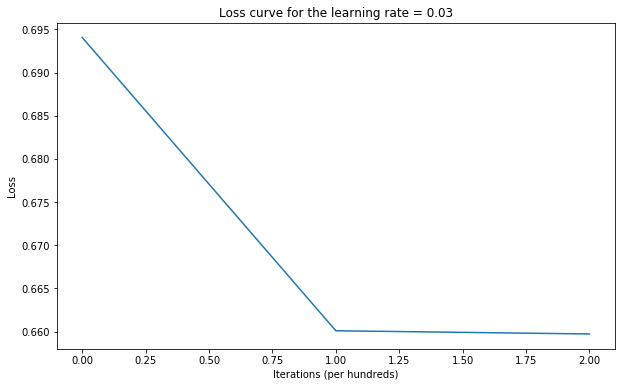

In [12]:
# Import training dataset
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


data = load_breast_cancer()

X = data.data
Y = data.target
X_train = np.array(X).T
y_train = np.array(Y)


# print the shape of input data and label vector
print(f"""Dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}""")

layers_dims = [X_train.shape[0], 30, 30, 1]


parameters = L_layer_model(X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=300)
print(parameters)